In [31]:
import numpy as np
# For File path joining operationns for Model Check pointing
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Relay Buffer

#### max_size : memory cannot be unbounded
#### State Memory Size = Max_memory_size * Input_Shape
#### Action Memory Size =  Max_memory_size * Actions
#### Reward Memory = Max_memory_size

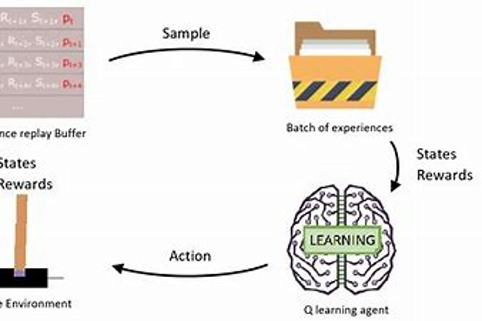

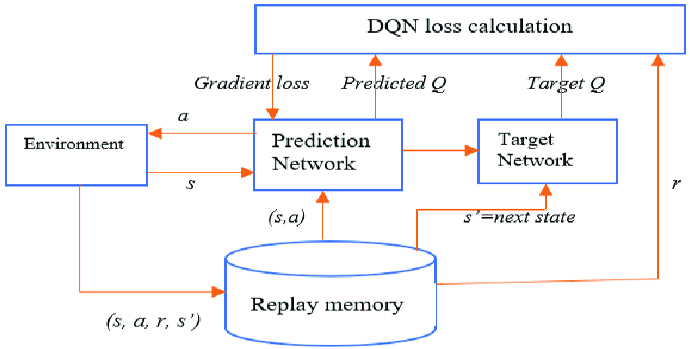

In [32]:
class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        
        
        # Determining the Position of the Available Memory
        # Modular ( Current Memory Counter , Max Memory Size )
        index = self.mem_cntr % self.mem_size

        # Trying to Store the Transitions
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        
        # If the Value of the Terminal State = 0 , 
        # i,e No future rewards follow from that Terminal State
        # Resetting the Episode back  to the intial State
        # A way to count that in our Learning Function by Terminal Flags as a Multiplicative Constant in Our LEarning Function
        self.terminal_memory[index] = done

        # Incrementing the memory Counter by 1
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        
        # How much of memory is filled up ? 
        max_mem = min(self.mem_cntr, self.mem_size)
        
        # Once the Memory is Sampled from tha range it should not be sampled again
        # replace = False , prevents from Double sampling
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones


# Networks

### CriticNetwork

In [33]:
import os
os.getcwd()

'M:\\IIST\\SEM 2\\REINFORCEMENT LEARNING\\Presentations'

In [34]:
cd "M:\IIST\SEM 2\REINFORCEMENT LEARNING\Presentations"

M:\IIST\SEM 2\REINFORCEMENT LEARNING\Presentations


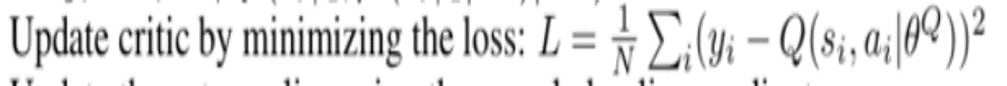

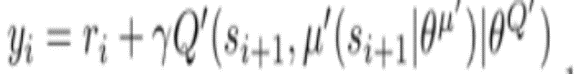

In [35]:
# Critic network is the Sub class of Keras.model class
class CriticNetwork(keras.Model):
    
    # Takes  Number of Fully connected dims , name and Check point Directory
    def __init__(self , fc1_dims=512, fc2_dims=512, name='critic', chkpt_dir='tmp/ddpg'):
        
        # Super Constructor
        super(CriticNetwork, self).__init__()
        
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
       
        
        # TensorFlow package keeps the NAme as a reserved variable
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        # saving the model 
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5')

        # First Fully connected Layer with relu activation Function
        self.fc1 = Dense(self.fc1_dims, activation='relu')
        # Second Fully connected Layer with relu activation Function
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        # Final output Layer
        self.q = Dense(1, activation=None)

    # Call function for Propogation Operation
    # Critic network Takes State and Action as input
    def call(self, state, action):
        
        # Passing the Concatenated State and action through First Fully Connected Layer and concatenate along the axis = 1
        action_value = self.fc1(tf.concat([state, action], axis=1))
        # Passing the output of the Fully Connected Layer 1 through the Fully Connected Layer 2
        action_value = self.fc2(action_value)

        # Find the Q_value
        q = self.q(action_value)

        return q

### ActorNetwork

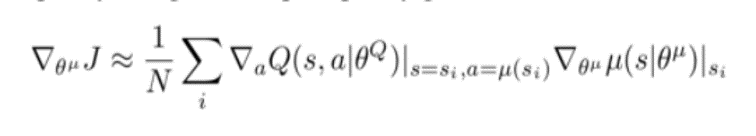

In [36]:
class ActorNetwork(keras.Model):
    
    # Takes  Number of Fully connected dims , Number of Actions ,name and Check point Directory
    def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2, name='actor',chkpt_dir='tmp/ddpg'):
        
        # Super Constructor
        super(ActorNetwork, self).__init__()
        
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        
        # Actor Network need to know How many actions it has
        self.n_actions = n_actions
        
        # First Fully connected Layer with relu activation Function
        self.model_name = name
        
        # check point Directory
        self.checkpoint_dir = chkpt_dir
        # saving the model 
        self.checkpoint_file = os.path.join(self.checkpoint_dir, self.model_name+'_ddpg.h5')
        
        # First Fully connected Layer with relu activation Function
        self.fc1 = Dense(self.fc1_dims, activation='relu')
        # Second Fully connected Layer with relu activation Function
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        # Final output Layer
        # Need an activation Function that bounds between +1 and -1
        # Most of our Environments have an acxtion Boundary of +1 and -1 
        self.mu = Dense(self.n_actions, activation='tanh')

        
    # Call function for Propogation Operation
    # Critic network Takes State as input
    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        # If action bounds not +1 or -1 , can multiply by a constant here 
        mu = self.mu(prob)

        return mu


### ddpg_tf2

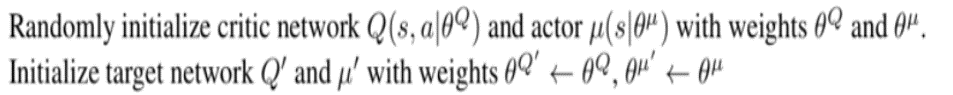

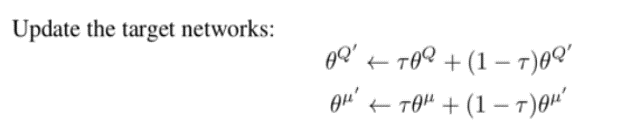

In [37]:
class Agent:
    
    # Learning rate for Actor network is alpha and Learning rate for Critic network is beta
    # beta > alpha
    # In policy Gradient Methods , The Policy approximation is Sensitive to the pertubation of parameters
    # So there will be Large changes in the actor network
    # adding Noise to the Deep Neural Network for Exploration , and clipping it into max and min actions for the environment
    # Passing that action into the open ai gym
    # gamma : Discount Factor for Update Equation
    # tau : Softupdate [ from the paper ]
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,
            gamma=0.99, n_actions=2, max_size=1000000, tau=0.005, 
            fc1=400, fc2=300, batch_size=64, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        
        # instantiating Actor Network
        self.actor = ActorNetwork(n_actions=n_actions, name='actor')
        # instantiating critic Network
        self.critic = CriticNetwork(n_actions=n_actions, name='critic')
        # instantiating target_actor Network
        self.target_actor = ActorNetwork(n_actions=n_actions, name='target_actor')
        # instantiating target_critic Network
        self.target_critic = CriticNetwork(n_actions=n_actions, name='target_critic')

        # Compiling Actor Netwroks using Adam Optimizer
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        # Compiling Critic Netwroks using Adam Optimizer
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        # Compiling target_actor Netwroks using Adam Optimizer
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        # Compiling target_critic Netwroks using Adam Optimizer
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        # Calling update_network_parameters
        self.update_network_parameters(tau=1)

    # update_network_parameters : Here we do the Hard Copy of the  initial weights of 
    # Actor and Critic Network to the Traget Actor and Target Critic Network
    def update_network_parameters(self, tau=None):
        # Hard Copy on the First call of the Function 
        # Soft Copy on the Every othyer Call of the Function
        if tau is None:
            tau = self.tau

        weights = []
        
        targets = self.target_actor.weights
        # Iterating over the Actor weights and appending Updated weights
        for i, weight in enumerate(self.actor.weights):
            
            # in the 1st iteration as tau = 1 then targets[i]*(1-tau) = 0 , So we get Hard Copy
            # in  the Remaining Iterations it will be a soft updte
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        
         # Iterating over the Critic weights and appending Updated weights
        for i, weight in enumerate(self.critic.weights):
            
            # in the 1st iteration as tau = 1 then targets[i]*(1-tau) = 0 , So we get Hard Copy
             # in  the Remaining Iterations it will be a soft updte
            weights.append(weight * tau + targets[i]*(1-tau))
        
        self.target_critic.set_weights(weights)

    # Interface Function for Agents Memory
    # remember function Calls the store_transition function
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # Model CheckPointing
    def save_models(self):
        print('... saving models ...')
        
        self.actor.save_weights(self.actor.checkpoint_file)
        
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        
        self.critic.save_weights(self.critic.checkpoint_file)
        
        self.target_critic.save_weights(self.target_critic.checkpoint_file)

    # load_models 
    def load_models(self):
        print('... loading models ...')
        
        self.actor.load_weights(self.actor.checkpoint_file)
        
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        
        self.critic.load_weights(self.critic.checkpoint_file)
        
        self.target_critic.load_weights(self.target_critic.checkpoint_file)

    # choose_action
    # Flag Variable : evaluate
    # This is used to Training vs Testing our agent
    # We use noise for the Exploration and Exploitation Dilemma
    # If we test to see how well the agent How well Learned ?
    # We don't have to add the Noise 
    # We can take the Deterministic Output of the Actor Network
    # We facilitate with a Boolean Flag here
    def choose_action(self, observation, evaluate=False):
        # Convert States to a Tensor 
        # Adding Extra Dimension to observation to add batch dimension
        # Deep Neural Networks Expect the Batch dimension as an input
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        
        # If we are not evaluating [i'e If we are Training]
        if not evaluate:
            # Random Normal Noise with mean = 0 , std = noise parameter
            actions += tf.random.normal(shape=[self.n_actions],
                    mean=0.0, stddev=self.noise)
        # note that if the environment has an action > 1, we have to multiply by
        # max action at some point
        
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        # actions is a tensor and we need to return zeroth element[numpy array]
        return actions[0]

    
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        # Sample The memory
        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        # Convert the Sampled memories into Tensors
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)
        
        # We are not Converting Terminal Flags into Tensors 
        # We are doing numpy array Operations with Terminal Flags
        
        # GradientTape() for the calculation of our Gradients
        with tf.GradientTape() as tape:
            
            target_actions = self.target_actor(states_)
            
            # Squeeze [new states and Target actions] along 1st Dimension 
            # we need to squeeze , Because of the Batch Dimension
            # Network Doesn't Learn without BAtch Dimension
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)
            
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            
            # When the episode is Over Done is True
            # So the Target for the terminal New state is just the Reward
            target = reward + self.gamma*critic_value_*(1-done)
            critic_loss = keras.losses.MSE(target, critic_value)
        
        # Gradient of Critic Network
        # Gradients of the Critic netwok w.r.t Critic Trainable Variables
        critic_network_gradient = tape.gradient(critic_loss,
                                            self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        
        # Actor Loss
        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        # Gradient of actor Network
        # Gradients of the actor netwok w.r.t actor Trainable Variables
        actor_network_gradient = tape.gradient(actor_loss, 
                                    self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))

        # As we have updated the Main Network 
        # We should also need to update the Target Network
        
        self.update_network_parameters()


# Actor Netwok Updates

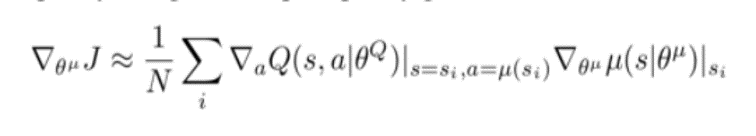

# Critic Network updates

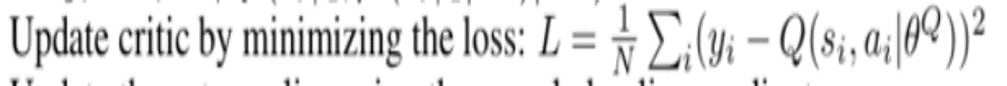

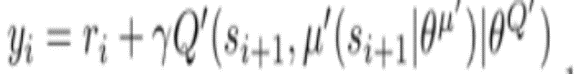

# Target Network Updatres

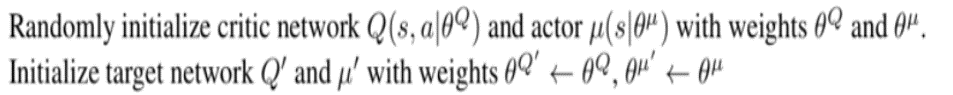

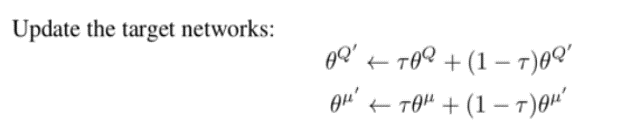